In [ ]:
from labeling import *
from trading_utils import *
from backtesting_process import *
from analysis import *
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Field Project Cartesius Capital: trend following

- Daniel de Miranda Almeida
- Kauan Mariani Ferreira
- Leonardo Alexandre da Silva Ferreira
- Pedro Henrique Coterli

Este relatório apresenta a metodologia, o processo e os resultados obtidos do projeto de campo realizado pelos alunos da FGV citados acima em conjunto com a Cartesius Capital.

## O problema

A Cartesius Capital é uma fundtech que faz a gestão de fundos multimercados usando sistemas de inteligência artificial preditiva. Sendo assim, utiliza de diversos modelos de aprendizado de máquina (machine learning) que geralmente necessitam de grandes bases de dados para a obtenção de relativa eficiência. Entretanto, há ativos que não apresentam histórico suficiente, em geral por terem iniciado recentemente.

Nosso problema era tentar criar uma abordagem para lidar com esses ativos, utilizando de técnicas de perseguição de tendência (trend following) na tentativa de realizar a geração de rótulos de transações (trades) com base nos poucos dados disponíveis.

## A abordagem

A abordagem criada por nós foi inspirada nas técnicas de **bagging** de machine learning, em que vários modelos medianos são utilizados conjuntamente na tentativa de gerarem uma predição de qualidade mais elevada.

### Os dados

Inicialmente, coletamos dos dados uma **lista de indicadores** relacionados a trend following e salvamos tudo isso em um DataFrame. Esses são os dados sobre os quais iremos trabalhar. Para isso, utilizamos a biblioteca [`ta`](https://technical-analysis-library-in-python.readthedocs.io/en/latest/), que já possui a implementação desses indicadores. Após esse cálculo, apenas realizamos a normalização dos novos dados. Esse processo pode ser encontrado no módulo [`indicators.py`](./indicators.py).

### A rotulagem

Em seguida, precisamos fazer a rotulagem dos dados de treinamento, indicando para cada dia do ativo, com base nos dados iniciais de OHLC (Open, High, Low, Close), a ação ideal (compra, venda ou neutralidade). Para isso, utilizamos do [**método de barreira tripla**](https://agorism.dev/book/finance/ml/Marcos%20Lopez%20de%20Prado%20-%20Advances%20in%20Financial%20Machine%20Learning-Wiley%20%282018%29.pdf), que está implementado no módulo [`labeling.py`](./labeling.py).

### O modelo

A próxima etapa compreende a seleção de um modelo de machine learning e seu treinamento com os dados e rótulos gerados anteriormente. Com o uso da biblioteca `sklearn`, optamos pelo emprego de um modelo de **random forest** para a predição, tanto por possuir um desempenho relativamente eficiente quanto por geralmente apresentar resultados mais precisos. Com isso, selecionamos um ano de dados para ser separado para o processo de backtest e utilizamos o restante para o treinamento do modelo. Além disso, temos a opção de realizar esse treinamento e predição de forma binarizada, com dois modelos simultâneos, um prevendo 0s e 1s e outro prevendo 0s e -1s. Essas etapas estão codadas nos módulos [`backtesting_process.py`](./backtesting_process.py) e [`main_process.py`](./main_process.py).

Por fim, utilizamos a biblioteca [`backtesting`](https://pypi.org/project/Backtesting/) para simular a estratégia prevista para o ano de backtest e visualizar seus resultados. Para isso, temos no módulo [`trading_utils.py`](./trading_utils.py) a implementação de uma classe base dessa estratégia na forma exigida pela biblioteca.

### A tunagem

Por último, dado que temos uma grande quantidade de hiperparâmetros variáveis, principalmente por parte dos próprios indicadores, utilizamos a biblioteca [`optuna`](https://optuna.org) para realizar sua tunagem. Para isso, implementamos no módulo [`tuner.py`](./tuner.py) esse processo, em que a biblioteca toma os diversos hiperparâmetros com seus respectivos intervalos de experimentação e realiza um processo de testes sucessivos sempre gerando novamente os dados de indicadores, treinando o modelo e observando seu desempenho no ano separado para validação (que deve ser diferente do ano de backtest). Finalizado isso, os melhores valores de hiperparâmetros são salvos em arquivos JSON na pasta [`hyperparams`](./hyperparams/).

## Análises preliminares

Antes de apresentarmos os resultados propriamente ditos do nosso modelo, vamos apresentar algumas análises que fizemos a respeito dos dados e do problema em algumas situações especificadas.

As funções utilizadas para a obtenção de dados para essas análises estão definidas no módulo [`analysis.py`](./analysis.py).

### Acurácia x Retorno

Aqui, tínhamos o objetivo de descobrir a acurácia mínima necessária para que nosso modelo pudesse ter um retorno consistentemente positivo. Basicamente, pegamos o rótulo dos dados e alteramos aleatoriamente uma certa quantidade de suas entradas. Assim, simulamos um retorno do modelo com cada percentual de acurácia desejado. Após isso, apenas realizamos o backtest dessa política e obtemos seu retorno final.

Abaixo temos os gráficos do retorno por acurácia em cada um dos nossos 4 ativos principais. A linha vermelha indica o montante inicial do processo.

In [2]:
prio_data = read_and_set_index("data/PRIO3.SA.csv")
tsla_data = read_and_set_index("data/TSLA.csv")
azul_data = read_and_set_index("data/AZUL4.SA.csv")
viva_data = read_and_set_index("data/VIVA3.SA.csv")

In [3]:
equities = {"PRIO3": test_accuracy(prio_data),
            "TSLA": test_accuracy(tsla_data),
            "AZUL4": test_accuracy(azul_data),
            "VIVA3": test_accuracy(viva_data)}

C:\Users\pedro\AppData\Local\Temp\ipykernel_11704\2342704654.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom = -100)


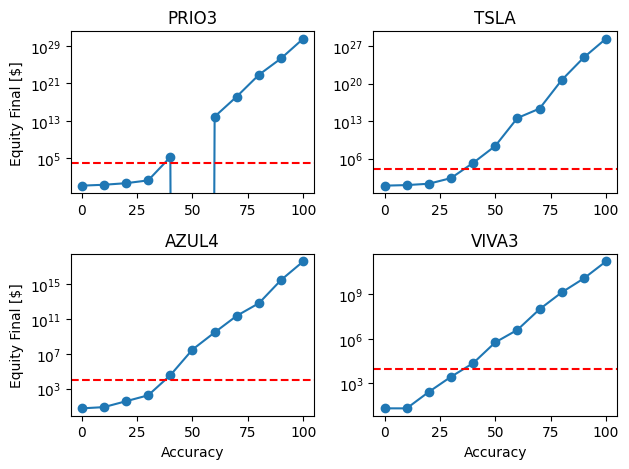

In [4]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(equities["PRIO3"].keys(), equities["PRIO3"].values(), marker = "o")
axs[0, 0].set_title('PRIO3')
axs[0, 0].set_ylabel('Equity Final [$]')

axs[0, 1].plot(equities["TSLA"].keys(), equities["TSLA"].values(), marker = "o")
axs[0, 1].set_title('TSLA')

axs[1, 0].plot(equities["AZUL4"].keys(), equities["AZUL4"].values(), marker = "o")
axs[1, 0].set_title('AZUL4')
axs[1, 0].set_ylabel('Equity Final [$]')
axs[1, 0].set_xlabel('Accuracy')

axs[1, 1].plot(equities["VIVA3"].keys(), equities["VIVA3"].values(), marker = "o")
axs[1, 1].set_title('VIVA3')
axs[1, 1].set_xlabel('Accuracy')

for ax in axs.flat:
    ax.set_yscale("log")
    ax.axhline(y = 10_000, color = "red", linestyle = "--")
    ax.set_ylim(bottom = -100)

plt.tight_layout()
plt.show()

Pode-se observar que uma acurácia de pouco mais de 30% já costuma ser suficiente para a obtenção de lucro. Assim, concluímos que essa seria a meta do nosso modelo.

### Quantidade de dados de treinamento x Retorno

A seguir, temos uma análise de como a quantidade de dados para treinamento do modelo influencia no retorno obtido no período de backtest. Em resumo, em cada modelo, determinamos que os dados de treinamento seriam os dados de um certo ano até 2023 (2024 é o ano de backtest), com esse certo ano sendo variado desde primeiro ano de dados até o próprio 2023.

Abaixo temos a visualização do retorno obtido com o treinamento começando em cada um desses anos, e isso para cada umas das nossas ações. Novamente, a linha vermelha indica o montante inicial do processo.

In [5]:
equities = {"PRIO3": test_train_time(prio_data, "Equity Final [$]"),
            "TSLA": test_train_time(tsla_data, "Equity Final [$]"),
            "AZUL4": test_train_time(azul_data, "Equity Final [$]"),
            "VIVA3": test_train_time(viva_data, "Equity Final [$]")}

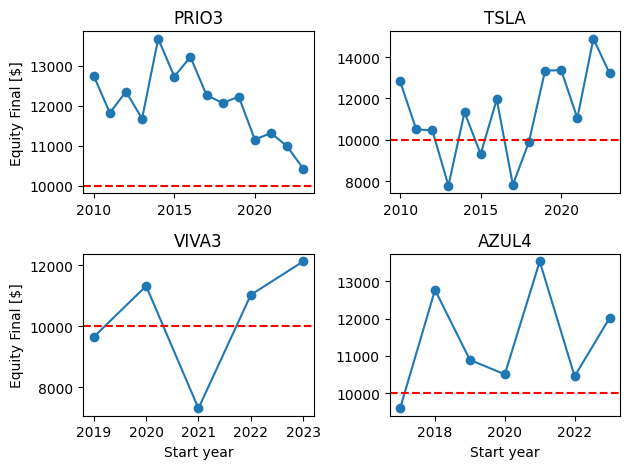

In [6]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(equities["PRIO3"].keys(), equities["PRIO3"].values(), marker = "o")
axs[0, 0].set_title('PRIO3')
axs[0, 0].set_ylabel('Equity Final [$]')

axs[0, 1].plot(equities["TSLA"].keys(), equities["TSLA"].values(), marker = "o")
axs[0, 1].set_title('TSLA')

axs[1, 0].plot(equities["VIVA3"].keys(), equities["VIVA3"].values(), marker = "o")
axs[1, 0].set_title('VIVA3')
axs[1, 0].set_ylabel('Equity Final [$]')
axs[1, 0].set_xlabel('Start year')

axs[1, 1].plot(equities["AZUL4"].keys(), equities["AZUL4"].values(), marker = "o")
axs[1, 1].set_title('AZUL4')
axs[1, 1].set_xlabel('Start year')

for ax in axs.flat:
    ax.axhline(y = 10_000, color = "red", linestyle = "--")

plt.tight_layout()
plt.show()

Infelizmente, observa-se que não há tanta relação entre a quantidade de dados de treino e o desempenho do nosso modelo.

### Quantidade de dados de treinamento x Taxa de acerto

Em seguida, temos uma análise semelhante à anterior, mas, ao invés de observarmos o retorno obtido, observamos a taxa de acerto (win rate) das transações do modelo.

Abaixo temos os gráficos do win rate com o treinamento começando em cada um desses anos, isso para cada umas dos 4 ativos considerados.

In [7]:
win_rates = {"PRIO3": test_train_time(prio_data, "Win Rate [%]"),
             "TSLA": test_train_time(tsla_data, "Win Rate [%]"),
             "AZUL4": test_train_time(azul_data, "Win Rate [%]"),
             "VIVA3": test_train_time(viva_data, "Win Rate [%]")}

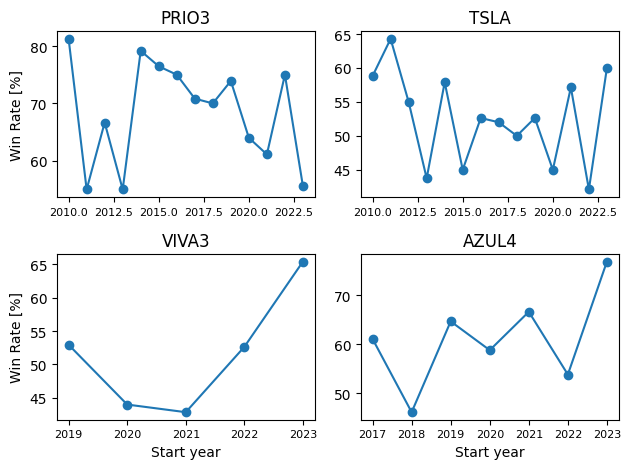

In [8]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(win_rates["PRIO3"].keys(), win_rates["PRIO3"].values(), marker = "o")
axs[0, 0].set_title('PRIO3')
axs[0, 0].set_ylabel('Win Rate [%]')

axs[0, 1].plot(win_rates["TSLA"].keys(), win_rates["TSLA"].values(), marker = "o")
axs[0, 1].set_title('TSLA')

axs[1, 0].plot(win_rates["VIVA3"].keys(), win_rates["VIVA3"].values(), marker = "o")
axs[1, 0].set_title('VIVA3')
axs[1, 0].set_ylabel('Win Rate [%]')
axs[1, 0].set_xlabel('Start year')

axs[1, 1].plot(win_rates["AZUL4"].keys(), win_rates["AZUL4"].values(), marker = "o")
axs[1, 1].set_title('AZUL4')
axs[1, 1].set_xlabel('Start year')

for ax in axs.flat:
    ax.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

Mais uma vez, nota-se que não há tanta relação entre a quantidade de dados de treino e o desempenho do nosso modelo.

## Análises dos resultados

Agora, começaremos a mostrar algumas análises realizadas com respeito aos resultados obtidos pelo nosso modelo.

### Volatilidade x Acurácia

Primeiramente, testamos nosso modelo em 20 ações de média movimentação diária de volatilidades variadas (calculadas com base em retorno logarítmico) e observamos a acurácia obtida. Abaixo está o gráfico gerado:

In [ ]:
df = pd.read_csv("results.csv")
fpath = Path(mpl.get_data_path(), r'C:\Users\kauan\AppData\Local\Microsoft\Windows\Fonts\Montserrat-Regular.ttf')

specific_offset = {"ITUB4": -0.005}
plot_graphs_style(df, "Volatility", "Accuracy Test","Volatilidade x Acurácia", 0.005, font=fpath, specific_offsets=specific_offset)

Nota-se que não temos uma correlação entre essas variáveis.

### Volatilidade x Retorno percentual

Em seguida, testamos o modelo nessas mesmas ações, mas agora observando o retorno percentual obtido.

In [ ]:
specific_offset = {"ITUB4": -4, "ITSA4":-4}
plot_graphs_style(df, "Volatility", "Percent Return","Volatilidade x Retorno Percentual", 3, font=fpath, specific_offsets=specific_offset)

Novamente, não notamos nenhuma correlação.

### Volatilidade x Win Rate

Nossa última análise com essas ações analisa a taxa de vitórias nas trades obtida.

In [ ]:
specific_offset = {"ITUB4": -1.5, "PETR4": -1.5, "PETR3": -1.5, "CMIG4": -1.5}
plot_graphs_style(df, "Volatility", "Win Rate","Volatilidade x Taxa de Vitórias", 1, font=fpath, specific_offsets=specific_offset)

Infelizmente, não obtemos nenhuma correlação mais uma vez.